# L4: Quantizing Models

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [14]:
from datasets import load_dataset

# Use input resolution of the network
input_shape = (1, 3, 1024, 2048)

# Load 100 RGB images of urban scenes 
dataset = load_dataset("UrbanSyn/UrbanSyn", 
                split="train", 
                data_files="rgb/*_00*.png")
dataset = dataset.train_test_split(1)

# Hold out for testing
calibration_dataset = dataset["train"]
test_dataset = dataset["test"]

Resolving data files:   0%|          | 0/99 [00:07<?, ?it/s]

Resolving data files:   0%|          | 0/99 [00:00<?, ?it/s]

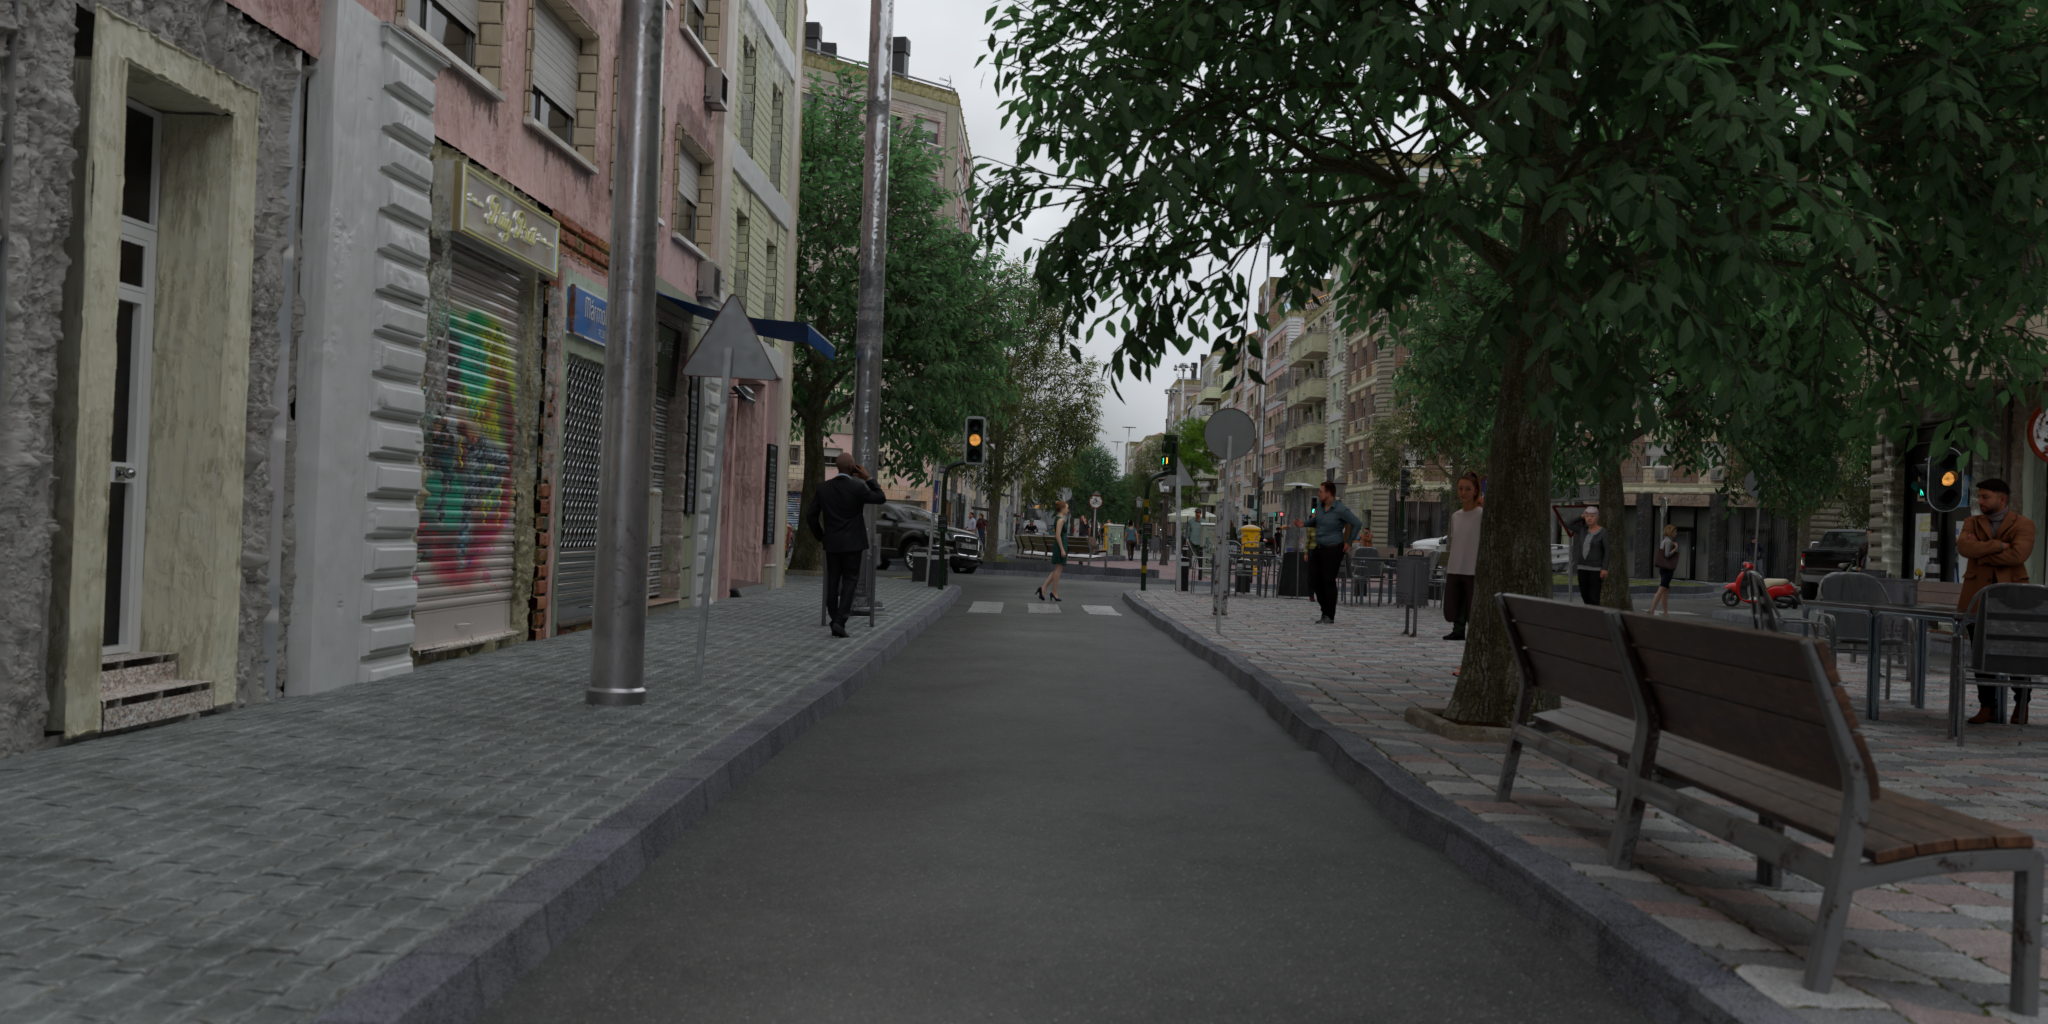

In [15]:
calibration_dataset["image"][0]

## Setup calibration/inference pipleline

In [16]:
import torch
from torchvision import transforms

# Convert the PIL image above to Torch Tensor
preprocess = transforms.ToTensor()

# Get a sample image in the test dataset
test_sample_pil = test_dataset[0]["image"]
test_sample = preprocess(test_sample_pil).unsqueeze(0) 
print(test_sample)


tensor([[[[0.3294, 0.3294, 0.3255,  ..., 0.4863, 0.4863, 0.4863],
          [0.3294, 0.3294, 0.3255,  ..., 0.4863, 0.4863, 0.4863],
          [0.3255, 0.3255, 0.3294,  ..., 0.4863, 0.4863, 0.4863],
          ...,
          [0.3686, 0.3647, 0.3529,  ..., 0.3216, 0.3255, 0.3255],
          [0.3216, 0.3216, 0.3059,  ..., 0.3255, 0.3255, 0.3255],
          [0.2706, 0.2824, 0.2863,  ..., 0.3294, 0.3216, 0.3216]],

         [[0.2941, 0.2863, 0.2824,  ..., 0.4431, 0.4431, 0.4471],
          [0.2902, 0.2824, 0.2824,  ..., 0.4431, 0.4471, 0.4471],
          [0.2824, 0.2824, 0.2745,  ..., 0.4471, 0.4471, 0.4431],
          ...,
          [0.3725, 0.3725, 0.3529,  ..., 0.3294, 0.3294, 0.3294],
          [0.3294, 0.3294, 0.3137,  ..., 0.3333, 0.3333, 0.3333],
          [0.2745, 0.2902, 0.2863,  ..., 0.3333, 0.3294, 0.3294]],

         [[0.2706, 0.2627, 0.2588,  ..., 0.3725, 0.3725, 0.3765],
          [0.2667, 0.2588, 0.2510,  ..., 0.3765, 0.3765, 0.3765],
          [0.2588, 0.2549, 0.2353,  ..., 0

In [17]:
import torch.nn.functional as F
import numpy as np
from PIL import Image

def postprocess(output_tensor, input_image_pil):

    # Upsample the output to the original size
    output_tensor_upsampled = F.interpolate(
        output_tensor, input_shape[2:], mode="bilinear",
    )

    # Get top predicted class and convert to numpy
    output_predictions = output_tensor_upsampled[0].argmax(0).byte().detach().numpy().astype(np.uint8)

    # Overlay over original image
    color_mask = Image.fromarray(output_predictions).convert("P")

    # Create an appropriate palette for the Cityscapes classes
    palette = [
        128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156,
        190, 153, 153, 153, 153, 153, 250, 170, 30, 220, 220, 0,
        107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60,
        255, 0, 0, 0, 0, 142, 0, 0, 70, 0, 60, 100, 0, 80, 100,
        0, 0, 230, 119, 11, 32]
    palette = palette + (256 * 3 - len(palette)) * [0]
    color_mask.putpalette(palette)
    out = Image.blend(input_image_pil, color_mask.convert("RGB"), 0.5)
    return out

## Setup model in floating point

Loading pretrained model state dict from /home/jovyan/.qaihm/models/ffnet/v1/ffnet40S/ffnet40S_dBBB_cityscapes_state_dict_quarts.pth
Initializing ffnnet40S_dBBB_mobile weights


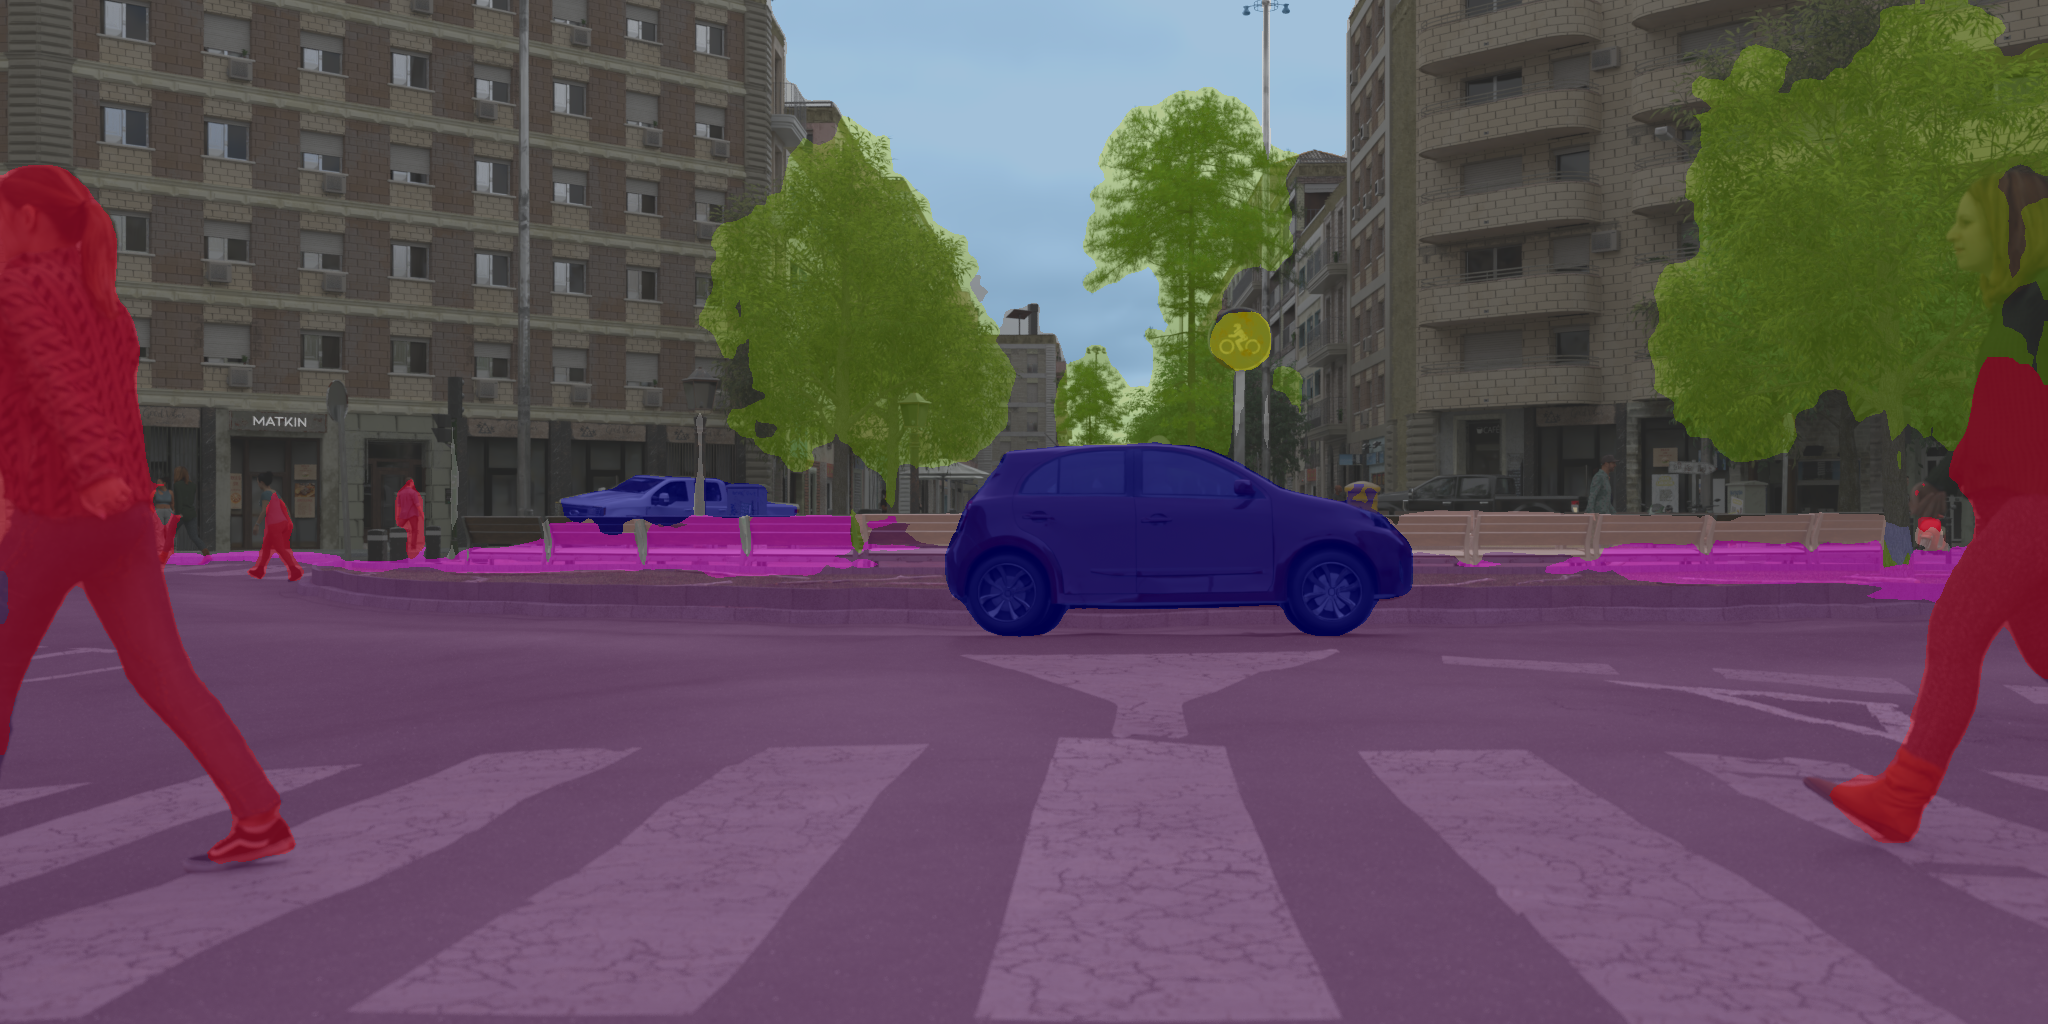

In [18]:
from qai_hub_models.models.ffnet_40s.model import FFNet40S
model = FFNet40S.from_pretrained().model.eval()

# Run sample output through the model
test_output_fp32 = model(test_sample)
test_output_fp32

postprocess(test_output_fp32, test_sample_pil)

## Prepare Quantized Model

In [19]:
from qai_hub_models.models._shared.ffnet_quantized.model import FFNET_AIMET_CONFIG
from aimet_torch.batch_norm_fold import fold_all_batch_norms
from aimet_torch.model_preparer import prepare_model
from aimet_torch.quantsim import QuantizationSimModel

# Prepare model for 8-bit quantization
fold_all_batch_norms(model, [input_shape])
model = prepare_model(model)

# Setup quantization simulator
quant_sim = QuantizationSimModel(
    model,
    quant_scheme="tf_enhanced",
    default_param_bw=8,              # Use bitwidth 8-bit
    default_output_bw=8,
    config_file=FFNET_AIMET_CONFIG,
    dummy_input=torch.rand(input_shape),
)

## Perform post training quantization

In [ ]:
size = 5  # Must be < 100

def pass_calibration_data(sim_model: torch.nn.Module, args):
    (dataset,) = args
    with torch.no_grad():
        for sample in dataset.select(range(size)):
            pil_image = sample["image"]
            input_batch = preprocess(pil_image).unsqueeze(0)

            # Feed sample through for calibration
            sim_model(input_batch)

# Run Post-Training Quantization (PTQ)
quant_sim.compute_encodings(pass_calibration_data, [calibration_dataset])

In [ ]:
test_output_int8 = quant_sim.model(test_sample)
postprocess(test_output_int8, test_sample_pil)

## Run Quantized model on-device

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

In [ ]:
import qai_hub
import qai_hub_models

from utils import get_ai_hub_api_token
ai_hub_api_token = get_ai_hub_api_token()

!qai-hub configure --api_token $ai_hub_api_token

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note:</b> To spread the load across various devices, we are selecting a random device. Feel free to change it to any other device you prefer.</p>

In [ ]:
devices = [
    "Samsung Galaxy S22 Ultra 5G",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S22+ 5G",
    "Samsung Galaxy Tab S8",
    "Xiaomi 12",
    "Xiaomi 12 Pro",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S23",
    "Samsung Galaxy S23+",
    "Samsung Galaxy S23 Ultra",
    "Samsung Galaxy S24",
    "Samsung Galaxy S24 Ultra",
    "Samsung Galaxy S24+",
]

import random
selected_device = random.choice(devices)
print(selected_device)

In [ ]:
%run -m qai_hub_models.models.ffnet_40s_quantized.export -- --device "$selected_device"